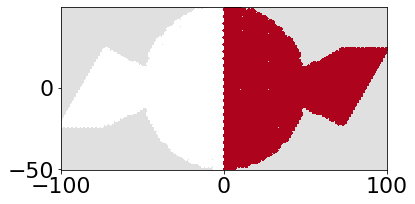

In [15]:
# ------------------------------------------
# Simulate a graphene quantum dot
# Creates the system in kwant and looks at properties like conductance and band structure
# ------------------------------------------


import matplotlib.pyplot as plt
import numpy as np
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
from tqdm import tqdm
from math import *
import scipy.integrate as integrate
import tinyarray
import warnings

# suppress numpy overflow warnings, np warns but does not error for big exponentiation
warnings.filterwarnings('ignore')

### define constants ###
k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
ev_to_j = q_e
h = 6.626176e-34
hbar = 1.054571e-34

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])


### Function to create our graphene quantum dot system
#
def make_system(r, t, left_pot, right_pot, leads, parallel = True, lead_zeeman = True):
    '''
    Create the system in kwant

    :param r: dot radius in angstroms
    :param t: hopping parameter
    :param left_pot: potential of the left lead
    :param right_pot:potential of the right lead, it is assumed left_pot > right_pot
    :param leads: boolean whether we want leads or not
    :param parallel: configuration of magnetization (parallel or anti parallel)
    :param lead_zeeman: inclue zeeman energy in the leads


    :return: system
    '''
    norbs = 2
    side = -1
    a = 2.46 # angstroms

    # Manually define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2) # constants

    lat = kwant.lattice.general([(a, 0), (a*sin_30, a*cos_30)], # basis vectors
                                 [(0, 0), (0, a / sqrt(3))],    # 2 points defining the 2 sublattices
                                norbs=norbs)
    electrode_bound = 1.5*r
    electrode_slope = 1/2
    b,c = lat.sublattices

    # hopping along the A field direction (perpendicular to B field)
    # These hoppings include the effects of a magnetic field <0, -Bx, 0>
    def hopy(site1, site2, B):
        x = site1.pos[0]
        return sigma_0 * t * np.exp(1j * B * x * q_e/hbar * a / sqrt(3))

    def hop_right(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)-B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)

    def hop_left(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)+B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)


    # shape functions for creating system
    def circle(pos):
        x, y = pos
        return x**2 + y**2 <= r**2

    # side = -1 for left, 1 for right
    def electrode_shape(pos):
        x,y = pos
        if x**2 + y**2 < r**2:
            return False
        return abs(y) + r/ 4 < side/abs(side) * x * electrode_slope and abs(x) < electrode_bound

    # make a lead to attach to the system
    def make_lead(pot):
        lead_lattice = kwant.lattice.honeycomb(a, norbs=norbs)
        sym_lead = kwant.TranslationalSymmetry(lead_lattice.vec((-1,0)))
        lead = kwant.Builder(sym_lead, conservation_law=-sigma_z)

        def lead_shape(pos):
            x, y = pos
            return abs(y) + r/4 < electrode_slope * electrode_bound-0.5*a

        def lead_potential(site, E_z):
            x,y = site.pos
            if not parallel and x < 0:
                E_z *= -1
            if not lead_zeeman:
                E_z = 0
            return pot * sigma_0 + E_z * sigma_z

        lead[lead_lattice.shape(lead_shape, (0, 0))] = lead_potential

        # lead hoppings do not include magnetic field (this is different from zeeman splitting)
        lead[lead_lattice.neighbors()] = t * sigma_0
        return lead

    # general potential function for dot, linearly varies from left_pot to right_pot
    def potential(site, E_z):
        x,y = site.pos
        m = (left_pot - right_pot)/(2*r)
        if not parallel and x < 0:
            E_z *= -1
        return (-m*(x-r) + right_pot) * sigma_0 + E_z * sigma_z


    def electrode_potential(site, E_z):
        x,y = site.pos
        if x < 0:
            pot = left_pot
        else:
            pot = right_pot
        if not parallel and x < 0:
            E_z *= -1
        if not lead_zeeman:
            E_z = 0

        return pot * sigma_0 + E_z * sigma_z

    syst = kwant.Builder()
    syst[lat.shape(circle, (0, 0))] = potential

    if leads:
        syst[lat.shape(electrode_shape, (-r,0))] = electrode_potential
        side *= -1
        syst[lat.shape(electrode_shape, (r,0))] = electrode_potential

    ### Split hoppings into direction and assign a value based on this ###
    hoppings_up = ((0,0),b,c)
    syst[kwant.builder.HoppingKind(*hoppings_up)] = hopy

    hoppings_left = ((0, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_left)] = hop_left

    hoppings_right = ((-1, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_right)] = hop_right
    ## hop_right and left might be swapped, if they are just negate B field

    ### clean up system, likely unneeeded
    syst.eradicate_dangling()

    if leads:
        syst.attach_lead(make_lead(pot = left_pot))
        syst.attach_lead(make_lead(pot = right_pot).reversed())

    return syst


def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1


def sort_evals(vals, vecs):
    vecs = [vecs[:,n] for n in range(len(vals))]
    print(np.shape(vecs), np.shape(vals))
    temp = sorted(zip(vals, vecs))
    vecs = list(np.array(temp)[:,1])
    return np.array(temp)[:,0], vecs

def plot_data(syst, ns,params):
    ham = syst.hamiltonian_submatrix(sparse=True, params = params)
    print("Solving N={} matrix".format(ham.shape[0]))
    evals, evecs = sla.eigsh(ham, max(ns)+1)
    evals, evecs = sort_evals(evals, evecs)
    for n in ns:
        wf = abs(evecs[n])**2
        def site_size(i):
            return 3 * wf[i] / wf.max()
        kwant.plot(syst, site_size=site_size, site_color=(0, 1, 1, 0.3),
               hop_lw=0.1, fig_size=(6,6))
    plt.plot(evals)
    plt.show()


t = -2.7 # hopping parameter in ev
doping_level = 0 # in ev
v_sd = 0 # in eV (not V, this is the energy difference, not the voltage difference!!!)

left_pot = v_sd/2
right_pot = -v_sd/2
syst = make_system(r=50,t=-t, left_pot=left_pot
                   , right_pot=right_pot, leads = True, parallel=False, lead_zeeman=True)
syst = syst.finalized()

# mapping functions to get the potential experienced by spin up and down electrons
def spin_down_map(i):
    spin_down_mask = tinyarray.array([[0,0],[0,1]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.5))
    return np.sum(spin_down_mask * hamiltonian)
def spin_up_map(i):
    spin_up_mask = tinyarray.array([[1,0],[0,0]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.5))
    return np.sum(spin_up_mask * hamiltonian)


### Increase font size
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

fig = plt.figure(figsize=(6,3))
ax = plt.gca()

kwant.plotter.map(syst, spin_up_map, ax = ax);
# kwant.plot(syst, pos_transform= lambda x: x*2.46/10, ax = ax)
ax.set_aspect('equal')
# plt.xlabel("X [nm]")
# plt.ylabel("Y [nm]")

plt.savefig("graphs/final figs/Graphene Quantum Dot")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:46<00:00,  2.81it/s]


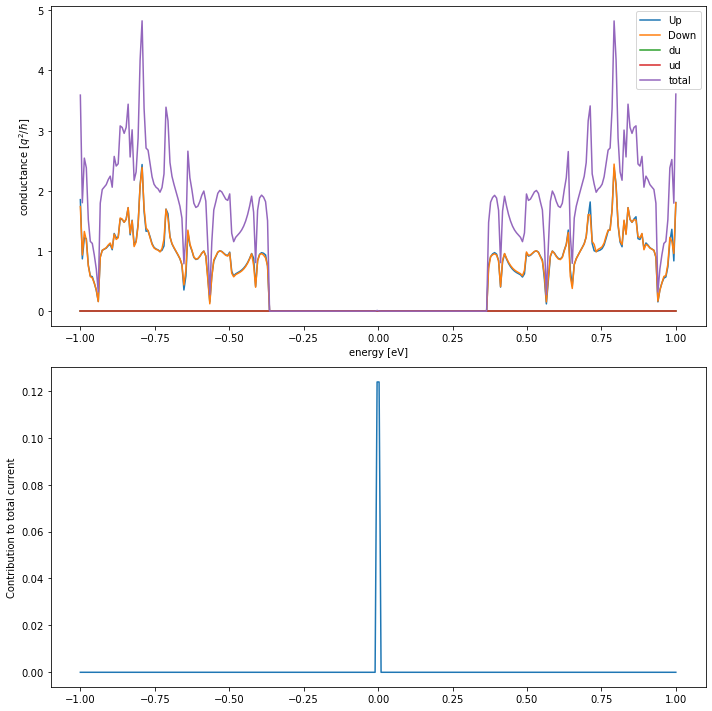

In [31]:

def fermi(eps, mu, T):
    '''
    Get the value of the specified Fermi distribution

    :param eps: the energy to get the occupation at in eV
    :param mu: the chemical potential / center of the distribution in eV
    :param T: temperature
    :return: Average occupation at the given energy
    '''
    eps *= ev_to_j
    mu *= ev_to_j
    return 1/(1+np.exp((eps-mu)/(k_b*T)))



def plot_conductance(syst, energies, mu_left, mu_right, temp, params, silent=False):
    '''
    Determine conductance and transport properties of a system for given energies

    :param syst: the finalized system to evaluate properties of
    :param energies: energies to look at conductance for [eV]
    :param mu_left: electrochemical potential of the left lead [eV]
    :param mu_right: electrochemical potential of the right lead [eV]
    :param temp: temperature [K]
    :param params: parameters for the system, dictionary defining B and E_z
    :param silent: whether to show progress / graphs, set to false if running for an IV curve ex
    :return: a tuple with transport information (total current [float], energies [array], total conductance [array], spin down conductance [array], spin up conductance [array])
    '''
    spin_ups = []
    spin_downs = []
    down_up = []
    up_down = []
    total = []
    conductance_quantum = q_e**2/h
    data2 = []
    current_sum = 0
    dE = energies[1] - energies[0]

    # make a progress bar if not silent
    iter_energies = energies
    if not silent:
        iter_energies = tqdm(iter_energies)

    for energy in iter_energies:

        # generate scattering matrix
        smatrix = kwant.smatrix(syst, energy, params = params)

        # total conductance
        spin_ups.append(smatrix.transmission((1,0), (0,0)))
        spin_downs.append(smatrix.transmission((1,1), (0,1)))
        down_up.append(smatrix.transmission((1,0), (0,1)))
        up_down.append(smatrix.transmission((1,1), (0,0)))
        total.append(smatrix.transmission(1,0))

        # asserting that there is no cross-spin current
        if down_up[-1] != 0 or up_down[-1] != 0:
            print("something odd is afoot")


        occupation_difference = (fermi(energy,mu_left, temp) - fermi(energy, mu_right, temp))

        # add current contribution from E to E + dE
        current_sum += dE * total[-1] * occupation_difference * conductance_quantum
        data2.append(occupation_difference)

    # plot information and save graphs if not silent
    if not silent:
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].plot(energies, np.array(spin_ups) , label="Up")
        axs[0].plot(energies, np.array(spin_downs) , label = "Down")
        axs[0].plot(energies, np.array(down_up), label="du")
        axs[0].plot(energies, np.array(up_down), label = "ud")
        axs[0].plot(energies, np.array(total) , label = "total")
        axs[0].set_xlabel("energy [eV]")
        axs[0].set_ylabel("conductance [$q^2$/$\hbar$]")
        axs[0].legend()

        axs[1].plot(energies, data2)
        axs[1].set_ylabel("Contribution to total current")

        plt.tight_layout()
        plt.savefig("graphs/conductance plot")
        plt.show()

    return current_sum, energies, total, spin_downs, spin_ups


def plot_bandstructure(flead, momenta, params):
    '''
    Plot the band structure of a given finalized lead
    :param flead: a finalized lead of interest
    :param momenta: momenta to evaluate over (usually just an array from -pi to pi)
    :param params: parameters for the system, defines B and E_z
    :return: a list of arrays corresponding to E(k) for each mode (I think, this may be wrong)
    '''
    bands = kwant.physics.Bands(flead, params = params)
    energies = [bands(k)/ev_to_j for k in tqdm(momenta)]

    plt.figure(figsize=(10,6))
    plt.plot(momenta, energies,alpha=0.5)

    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [eV]")
    plt.grid()
    plt.show()
    return energies



def plot_spectrum_over_B_fields(syst, Bfields, k):
    '''
    Find the k lowest eigenvalues for the system at given B fields, should see Landau levels form eventually
    :param syst: system in question
    :param Bfields: B fields to iterate over
    :param k: number of eigen values to look at
    :return: a tuple (B fields looked at, 2D array of eigenvalues with a list for each B)
    '''
    energies = []
    for B in tqdm(Bfields):
        # Obtain the Hamiltonian as a sparse matrix
        ham_mat = syst.hamiltonian_submatrix(params=dict(B=B, E_z=0), sparse=True)

        # we only calculate the k lowest eigenvalues
        ev = sla.eigsh(ham_mat.tocsc(), k=k, sigma=0,
                       return_eigenvectors=False)

        energies.append(ev)

    return Bfields, energies


# Example of finding the conductance plot for a system

# define system constants
temp = 5
doping_level = 0
v_sd = 5/1000
left_pot = v_sd / 2
right_pot = -v_sd / 2
syst = make_system(r=50, t=-t, left_pot=left_pot, right_pot=right_pot, leads=True,
                   parallel = False, lead_zeeman=True)
syst = syst.finalized()

# look at energies around the doping level
span = max(1, left_pot - right_pot)
energies = np.linspace(-span + doping_level, span + doping_level , 300)
params = dict(B=0, E_z = 0.01)

out = \
    plot_conductance(syst, energies, doping_level+left_pot, doping_level+right_pot, temp,
                 params = params, silent=False)

# save the data in a numpy archive for later
np.save("data/antiparallel_5mV_Z10meV.npy", out)



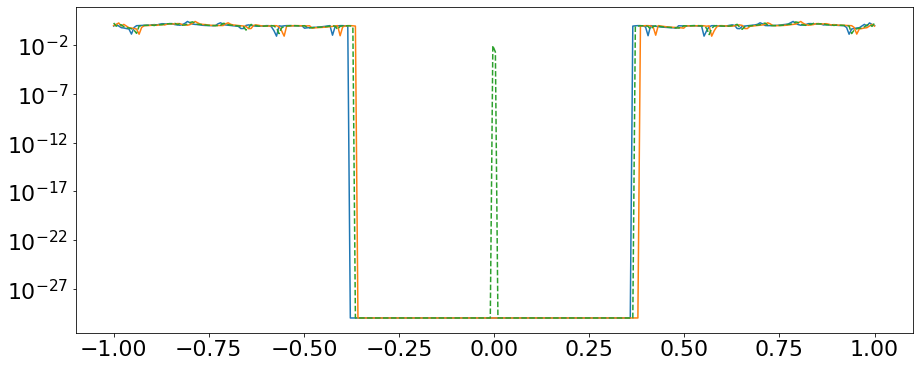

In [14]:
### Cell to compare 2 different conductance plots on the same array ###
plt.figure(figsize=(15,6))

### First file ###
out = np.load("data/testing_parallel.npy", allow_pickle=True)
current, energies, total, spin_downs, spin_ups = out
plt.plot(energies, np.array(spin_downs) + 1e-30,)
plt.plot(energies, np.array(spin_ups) + 1e-30,)

### Second file ###
out = np.load("data/testing_antiparallel.npy", allow_pickle=True)
current, energies, total, spin_downs, spin_ups = out
plt.plot(energies, np.array(spin_ups) + 1e-30,"--")
plt.yscale('log')

plt.show()

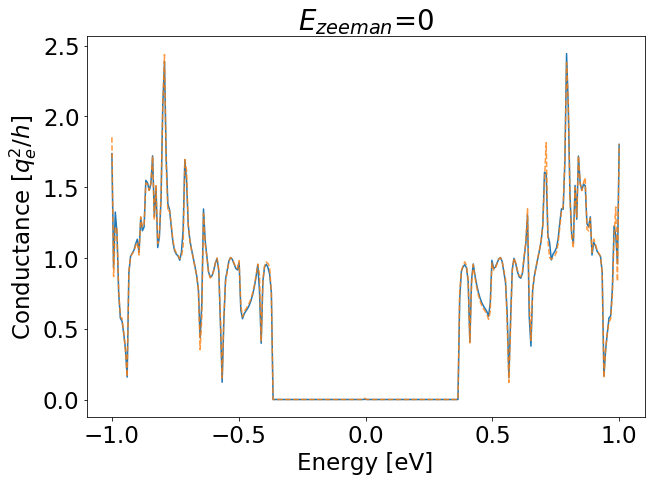

2.278428093645485e+18
96


In [16]:
### Cell for properly formatting conductance plots for putting into a poster ###
plt.figure(figsize=(10,7))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 23}

plt.rc('font', **font)

out = np.load("data/testing_antiparallel.npy", allow_pickle=True)
current, energies, total, spin_downs, spin_ups = out
plt.plot(energies, spin_downs,alpha=1, label="Down")
plt.plot(energies, spin_ups,"--", alpha=0.8, label="Up")
# plt.legend()
plt.xlabel("Energy [eV]")
plt.ylabel("Conductance [$q_e^2/h$]")
plt.title("$E_{zeeman}$=0")
plt.savefig("graphs/final figs/antiparallel conductance")
plt.show()

### Little script to see when the gap ends ###
for i in range(1,len(energies)):
    if total[-i] == 0:
        print(energies[-i]/ev_to_j)
        print(i)
        break

### Reset font back to normal ###
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)